# Voronoi Graphs

In [1]:
# Make the relevant imports including Voronoi methods
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from bresenham import bresenham
from planning_utils import create_grid
from itertools import compress


In [2]:
plt.rcParams["figure.figsize"] = [12, 12]

In [3]:
# Read in the obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)

drone_altitude = 5
safety_distance = 5



In [4]:
from shapely.geometry import Point
import shapely.prepared
from descartes import PolygonPatch


def plot_polygons(polys):
    BLUE = '#6699cc'
    GRAY = '#999999'
    BLACK = '#000000'

    fig, ax = plt.subplots()
    
    #plt.plot([-100, 100],[-200, 200], 'b-')
    
    if polys.geom_type == 'Polygon':
        patchc = PolygonPatch(polys, fc=BLUE, ec=BLUE, alpha=0.5, linewidth=3)
        ax.add_patch(patchc)
    elif polys.geom_type == 'MultiPolygon':
        for p in polys:
            patchp = PolygonPatch(p.buffer(0.001), fc=BLUE, ec=BLACK, linewidth=3)
            #print(patchp)
            ax.add_patch(patchp)

    bounds = polys.bounds
    print(bounds)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_aspect("equal")
    plt.show()


3845
{130.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 145.0, 140.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 149.0, 28.0, 29.0, 154.0, 159.0, 32.0, 33.0, 34.0, 160.0, 36.0, 31.0, 133.0, 40.0, 41.0, 169.0, 171.0, 44.0, 173.0, 45.0, 174.0, 48.0, 172.0, 50.0, 51.0, 53.0, 55.0, 183.0, 138.0, 58.0, 59.0, 60.0, 61.0, 57.0, 67.0, 69.0, 197.0, 75.0, 78.0, 80.0, 81.0, 83.0, 212.0, 84.0, 90.0, 92.0, 93.0, 94.0, 95.0, 99.0, 100.0, 104.0, 105.0, 109.0, 111.0, 117.0, 118.0, 151.0, 121.0, 123.0}
Reduced 3845 polygons to 496 polygons in 1.4758970737457275 seconds
(-320.2389, -449.2315, 609.7611, 480.7685)


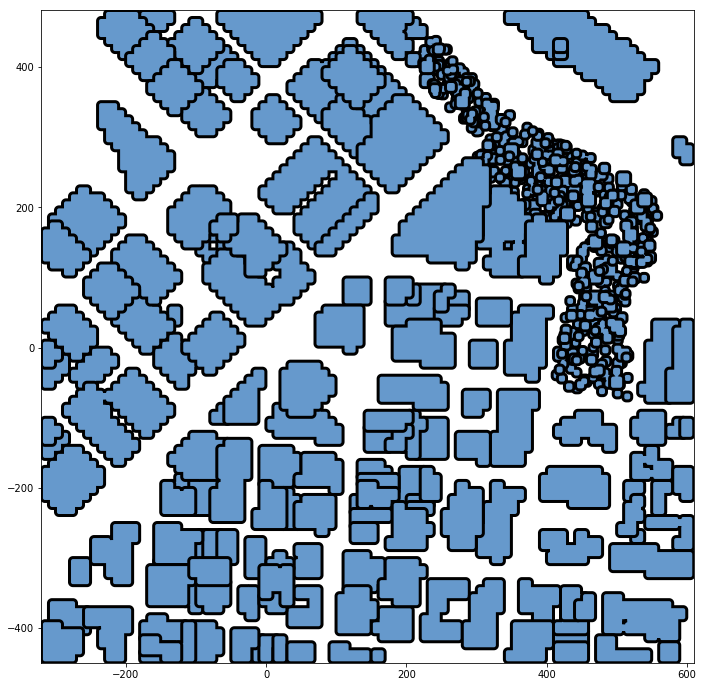

In [5]:
import shapely.ops
from prm import PolyLibrary, CollidersData
PL = PolyLibrary(data)
CD = CollidersData(data)

print(len(PL.polygons))

heights = [round(h) for p, h in PL.polygons]
print(set(heights))

t0 = time.time()
polys = []
for ht in set(heights):
    #print("Collecting polygons of height = {}".format(ht))
    polyset = [p.buffer(5) for p, h in PL.polygons if round(h) == ht]
    #print("Found {} polygons.".format(len(polyset)))
    union = shapely.ops.unary_union(polyset)
    try: 
        polys += list(union)
    except TypeError:
        polys.append(union)

e_time = time.time() - t0
print("Reduced {} polygons to {} polygons in {} seconds".format(len(PL.polygons),
                                                               len(polys), e_time))
#print(polys)

plot_polygons(shapely.geometry.MultiPolygon(polys))



Reduced 3845 polygons to 555 polygons in 0.7199709415435791 seconds
555
MultiPolygon
Further reduced 555 polygons to 485 polygons in 0.18729877471923828 seconds
Further reduced 485 polygons to 45 polygons in 0.18024492263793945 seconds
Total runtime: Reduced 3845 polygons to 45 polygons in 1.0875146389007568 seconds
Reduced 3845 polygons to 52 polygons in 0.9576449394226074 seconds
485
45
52
(-315.2399, -444.23249999999996, 604.7621, 475.7695)


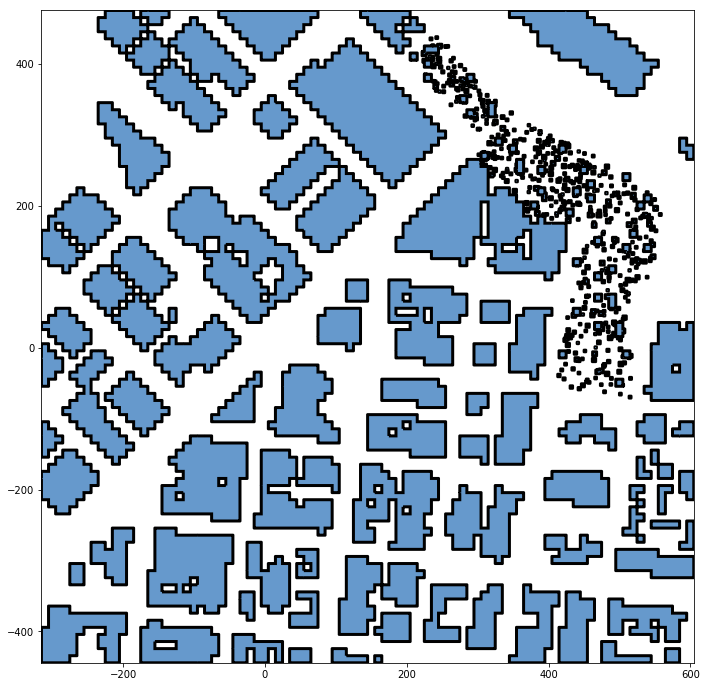

(-315.2399, -444.23249999999996, 604.7621, 475.7695)


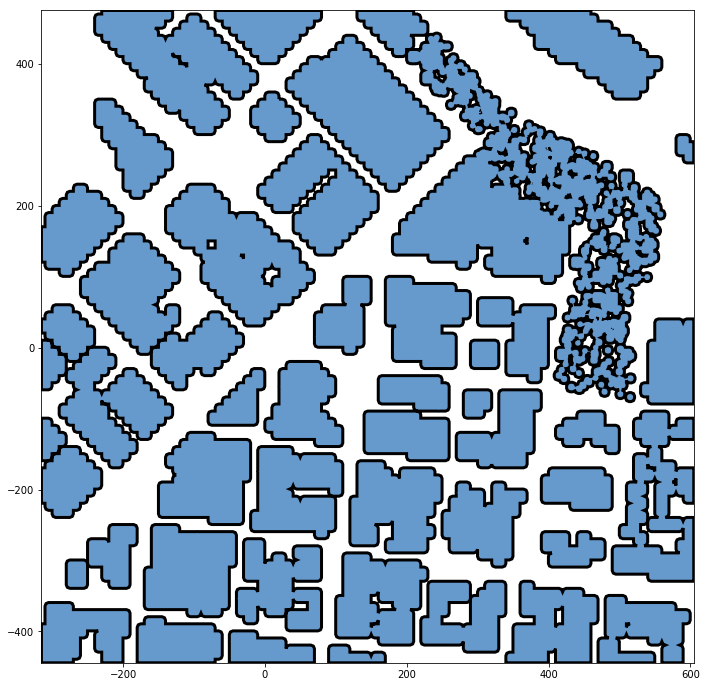

(-315.2399, -444.23249999999996, 604.7621, 475.7695)


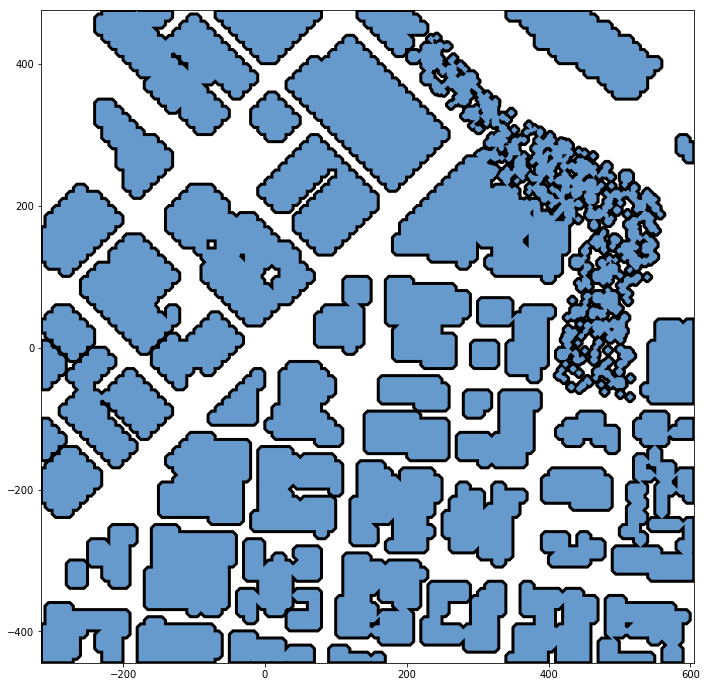

In [6]:
total_time = 0
t0 = time.time()
poly_set = shapely.ops.unary_union([p for p, h in PL.polygons if h > drone_altitude - safety_distance])
e_time = time.time() - t0
print("Reduced {} polygons to {} polygons in {} seconds".format(len(PL.polygons),
                                                                len(poly_set.geoms),
                                                                e_time))
total_time += e_time
print(len(poly_set.geoms))
#print(list(out))
print(poly_set.geom_type)

n_polys = len(poly_set.geoms)
# Run it again to fix the overlapping bits
t0 = time.time()
poly_set = shapely.ops.unary_union([p.buffer(0.001,
                                             cap_style=shapely.geometry.CAP_STYLE.square,
                                             join_style=shapely.geometry.JOIN_STYLE.bevel,
                                             resolution=1) for p in list(poly_set)])
e_time = time.time() - t0
print("Further reduced {} polygons to {} polygons in {} seconds".format(n_polys,
                                                                len(poly_set.geoms),
                                                                e_time))
total_time += e_time
n_polys = len(poly_set.geoms)
t0 = time.time()
poly_buffer = shapely.ops.unary_union([p.buffer(safety_distance, 
                                                cap_style=shapely.geometry.CAP_STYLE.square,
                                                join_style=shapely.geometry.JOIN_STYLE.bevel,
                                                resolution=1) for p in list(poly_set)])
boundary = shapely.geometry.box(*poly_set.bounds)
poly_buffer = boundary.intersection(poly_buffer)
e_time = time.time() - t0
print("Further reduced {} polygons to {} polygons in {} seconds".format(n_polys,
                                                                len(poly_buffer.geoms),
                                                                e_time))
total_time += e_time
print("Total runtime: Reduced {} polygons to {} polygons in {} seconds".format(len(PL.polygons),
                                                                               len(poly_buffer.geoms),
                                                                               total_time))

t0 = time.time()
polys = shapely.ops.unary_union(
    [p.buffer(safety_distance,
              resolution=1) for p, h in PL.polygons \
     if h > drone_altitude - safety_distance])
polys = boundary.intersection(polys)
e_time = time.time() - t0
print("Reduced {} polygons to {} polygons in {} seconds".format(len(PL.polygons),
                                                                len(polys.geoms),
                                                                e_time))


print(len(poly_set.geoms))
print(len(poly_buffer.geoms))
print(len(polys.geoms))
plot_polygons(poly_set)
plot_polygons(poly_buffer)
plot_polygons(polys)


In [7]:
# Here you'll modify the `create_grid()` method from a previous exercise
# In this new function you'll record obstacle centres and
# create a Voronoi graph around those points
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """
            
    grid, _ = create_grid(data, drone_altitude, safety_distance)
    
    grid_min = np.array(CD.min)[0:2]
    
    points = (data[:,0:2] - grid_min).tolist()
    height = data[:,2] + data[:,5] + safety_distance
    points = list(compress(points, (height > drone_altitude).tolist()))

    # TODO: create a voronoi graph based on
    # location of obstacle centres
    graph = Voronoi(points)
    # voronoi_plot_2d(graph)  # uncomment to view raw voronoi graph
    
    print(grid.shape)
    north_size, east_size = grid.shape
    # TODO: check each edge from graph.ridge_vertices for collision
    edges = []
    for v in graph.ridge_vertices:
        p1 = graph.vertices[v[0]]
        p2 = graph.vertices[v[1]]
        # Converting to int here would technically modify the 
        # voronoi diagram, so we'll use a new var name.
        p1i = [int(p) for p in p1]
        p2i = [int(p) for p in p2]
        
        if p1[0] < 0 or p1[0] >= north_size or \
           p2[0] < 0 or p2[0] >= north_size or \
           p1[1] < 0 or p1[1] >= east_size or \
           p2[1] < 0 or p2[1] >= east_size or \
           grid[p1i[0], p1i[1]] or grid[p2i[0], p2i[1]]:
                continue
                
        # Then you can test each pair p1 and p2 for collision using Bresenham
        # (need to convert to integer if using prebuilt Python package)
        # If the edge does not hit an obstacle
        # add it to the list
        line = bresenham(p1i[0], p1i[1], p2i[0], p2i[1])
        #print([p for p in pts])
        # Check to see if any of the points are in collision
        in_collision = np.any([grid[p[0], p[1]] for p in line])
        if not in_collision:
            edges.append((tuple(p1+grid_min), tuple(p2+grid_min)))
    
    return grid, edges

In [8]:
def create_voronoi(data, drone_altitude, safety_distance, polys):
    """
    Returns a Voronoi graph edges given obstacle data and the
    drone's altitude.
    """
    grid, grid_min = create_grid(data, drone_altitude, safety_distance)
    
    points = data[:,0:2].tolist()
    height = data[:,2] + data[:,5] + safety_distance
    points = list(compress(points, (height > drone_altitude).tolist()))

    poly_prep = shapely.prepared.prep(polys)
    # Create a voronoi graph based on location of obstacle centres
    graph = Voronoi(points)
    #voronoi_plot_2d(graph)  # uncomment to view raw voronoi graph
    
    x_min, y_min, x_max, y_max = polys.bounds
    
    # Check each edge from graph.ridge_vertices for collision
    edges = []
    for v in graph.ridge_vertices:
        p1 = graph.vertices[v[0]]
        p2 = graph.vertices[v[1]]
        
        if p1[0] < x_min or p1[0] > x_max or \
           p2[0] < x_min or p2[0] > x_max or \
           p1[1] < y_min or p1[1] > y_max or \
           p2[1] < y_min or p2[1] > y_max or \
           poly_prep.intersects(shapely.geometry.LineString([tuple(p1), tuple(p2)])):
                continue
                
        edges.append((tuple(p1), tuple(p2)))
    
    return edges

In [9]:
def create_voronoi2(data, drone_altitude, safety_distance, polys):
    """
    Returns a Voronoi graph edges given obstacle data and the
    drone's altitude.
    """
    grid, grid_min = create_grid(data, drone_altitude, safety_distance)
    
    points = data[:,0:2].tolist()
    height = data[:,2] + data[:,5] + safety_distance
    points = list(compress(points, (height > drone_altitude).tolist()))

    poly_prep = shapely.prepared.prep(polys)
    bounding_box = shapely.geometry.box(*polys.bounds)
    
    # Create a voronoi graph based on location of obstacle centres
    graph = Voronoi(points)
    #voronoi_plot_2d(graph)  # uncomment to view raw voronoi graph
    
    # Check each edge from graph.ridge_vertices for collision
    in_ = list(shapely.geometry.MultiLineString(graph.vertices[graph.ridge_vertices].tolist()))

    keep = lambda x: (not poly_prep.intersects(x)) and not (bounding_box.crosses(x) or bounding_box.disjoint(x))
    out_ = list(filter(keep, in_))

    return [np.array(l) for l in out_]

In [10]:
# Define a flying altitude (feel free to change this)
t0 = time.time()
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
e_time = time.time() - t0
print('Found {} edges in {} seconds.'.format(len(edges), e_time))

t0 = time.time()
edges2 = create_voronoi(data, drone_altitude, safety_distance, poly_buffer)
e_time = time.time() - t0
print('Found {} edges in {} seconds.'.format(len(edges2), e_time))

t0 = time.time()
edges3 = create_voronoi2(data, drone_altitude, safety_distance, poly_buffer)
e_time = time.time() - t0
print('Found {} edges in {} seconds.'.format(len(edges3), e_time))

(921, 921)
Found 1402 edges in 0.5711572170257568 seconds.
Found 1589 edges in 0.6934480667114258 seconds.
Found 1589 edges in 0.8036510944366455 seconds.


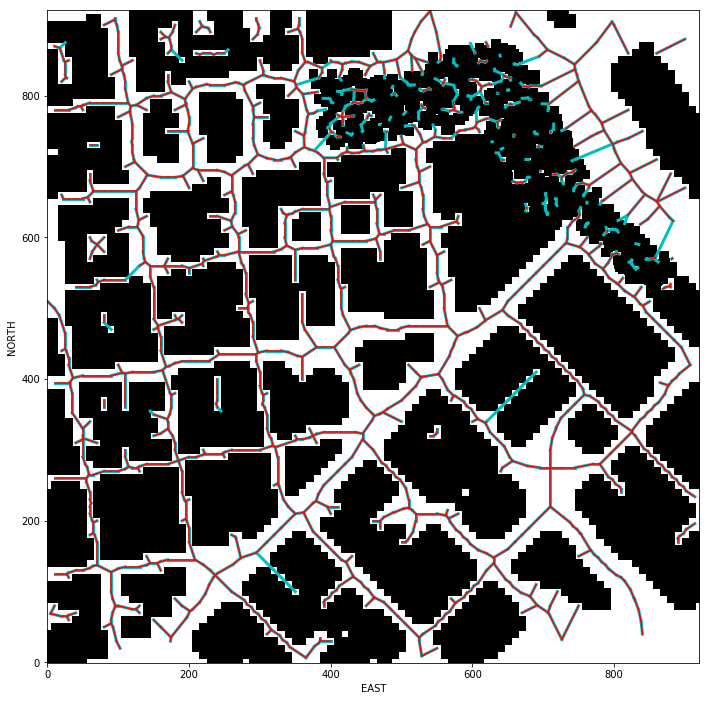

In [11]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys') 

xmin, ymin, xmax, ymax = poly_set.bounds
for e in edges3:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1]-ymin, p2[1]-ymin], [p1[0]-xmin, p2[0]-xmin], 'c-', linewidth=3)

# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1]-ymin, p2[1]-ymin], [p1[0]-xmin, p2[0]-xmin], 'r-')

#plt.xlim(-100, 1000)
#plt.ylim(-100, 1000)
    
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Elapsed time: 0.6038458347320557
Reduced 3845 polygons to 111 polygons in 0.9009850025177002 seconds
Elapsed time: 1.5488309860229492


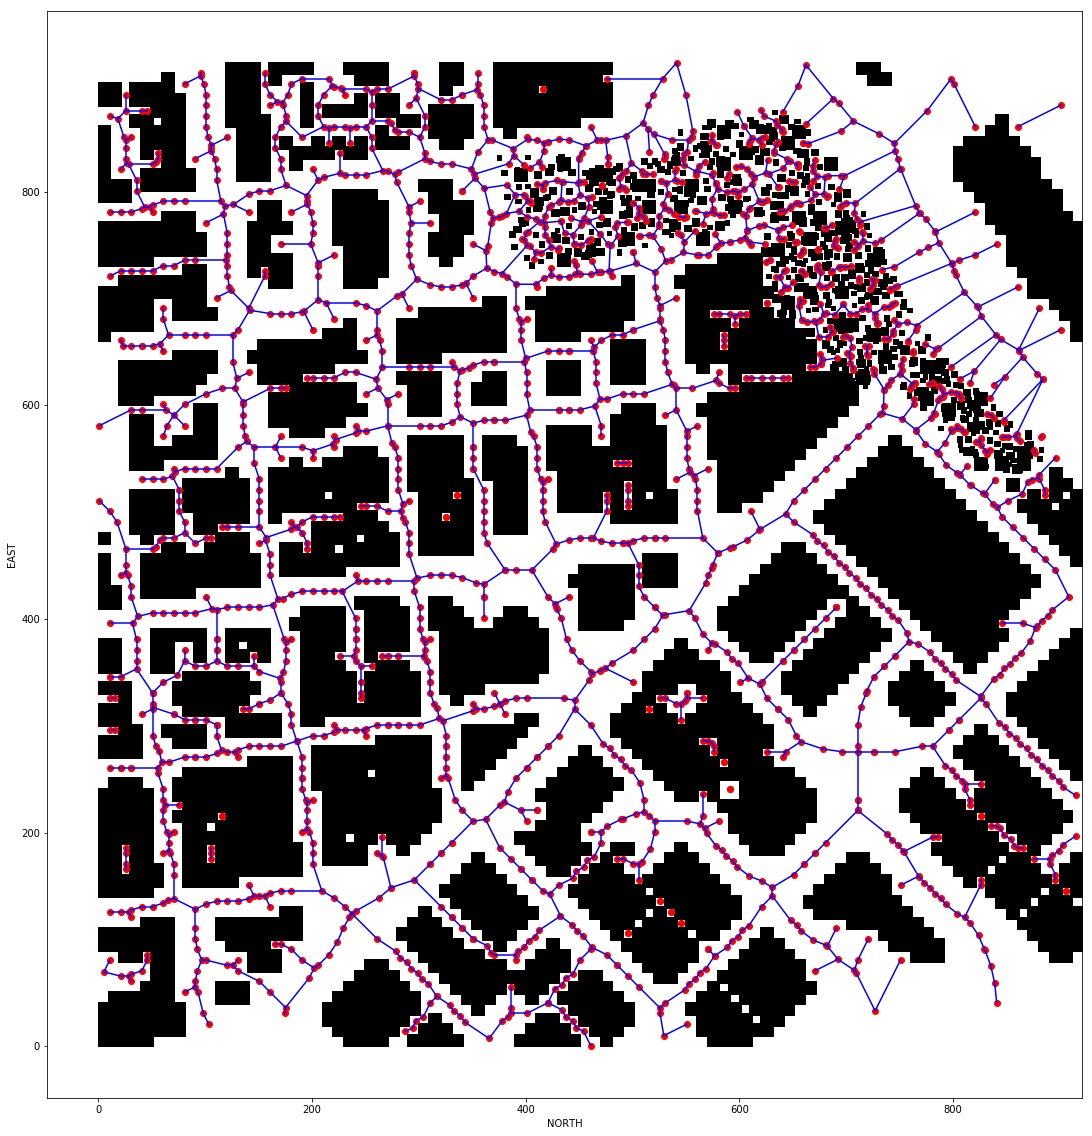

In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt
from voronoi_planner import VoronoiPlanner

plt.rcParams['figure.figsize'] = 20, 20

# Read in the obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)

drone_altitude = 5
safety_distance = 4

vp = VoronoiPlanner(data, safety_distance)

t0 = time.time()
g1 = vp.create_voronoi_grid(drone_altitude)
print("Elapsed time: {}".format(time.time() - t0))
t0 = time.time()
g2 = vp.create_voronoi(drone_altitude)
print("Elapsed time: {}".format(time.time() - t0))

fig = plt.figure()

from planning_utils import create_grid
grid, grid_min = create_grid(data, 1, 1)
plt.imshow(grid, cmap='Greys', origin='lower')

# Add code to visualize path here
nmin, emin = grid_min

# draw nodes
for n1 in g2.nodes:
    plt.scatter(n1[1]-emin, n1[0]-nmin, c='red')
    
# draw edges
for (n1, n2) in g2.edges:
    plt.plot([n1[1]-emin, n2[1]-emin], [n1[0]-nmin, n2[0]-nmin], 'blue')
    
plt.xlabel('NORTH')
plt.ylabel('EAST')
plt.show()

[solution](/notebooks/Voronoi-Solution.ipynb)